# Tibia Auction Market Analysis - Data Exploration

## Analysis Goals:
1. **Data Exploration** - understanding data structure and quality
2. **Price Trend Analysis** - identifying temporal patterns
3. **World Segmentation** - grouping by market characteristics
4. **Preparation for Predictive Modeling**

## Research Questions:
- Which factors most influence character prices?
- Are there differences between worlds (PvP vs PvE)?
- What does seasonality look like in the market?
- Can we predict future prices?


Libraries imports

In [72]:
# Data manipulation and analysis
import pandas as pd
import numpy as np

# Database connection
import psycopg2
from sqlalchemy import create_engine, text


# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Statistical analysis
from scipy.stats import pearsonr

# Configuration
import warnings
warnings.filterwarnings('ignore')

# Display settings
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-darkgrid')

print("Libraries imported successfully.")

Libraries imported successfully.


Connection with database

In [73]:
import os
from dotenv import load_dotenv

# Load environment variables
load_dotenv()

# Database connection config from environment variables
DB_CONFIG = {
    'host': os.getenv('DB_HOST', 'localhost'),
    'port': os.getenv('DB_PORT', '5432'),
    'database': os.getenv('DB_NAME', 'auction_data'),
    'user': os.getenv('DB_USER', 'scraper'),
    'password': os.getenv('DB_PASSWORD')
}

# Create connection string
connection_string = f"postgresql://{DB_CONFIG['user']}:{DB_CONFIG['password']}@{DB_CONFIG['host']}:{DB_CONFIG['port']}/{DB_CONFIG['database']}"

# Create engine
engine = create_engine(connection_string)

print("Database connection configured.")


Database connection configured.


In [75]:
index_queries = [
    "CREATE INDEX IF NOT EXISTS idx_auctions_character_id ON auctions(character_id);",
    "CREATE INDEX IF NOT EXISTS idx_auctions_filters ON auctions(has_been_bidded, is_historical);",
    "CREATE INDEX IF NOT EXISTS idx_characters_skills_id ON characters(skills_id);",
    "CREATE INDEX IF NOT EXISTS idx_characters_world_id ON characters(world_id);"
]

for query in index_queries:
    try:
        with engine.connect() as conn:
            conn.execute(text(query)) 
            conn.commit()              
        print(f"Index created: {query}")
    except Exception as e:
        print(f"Error: {e}")


Index created: CREATE INDEX IF NOT EXISTS idx_auctions_character_id ON auctions(character_id);
Index created: CREATE INDEX IF NOT EXISTS idx_auctions_filters ON auctions(has_been_bidded, is_historical);
Index created: CREATE INDEX IF NOT EXISTS idx_characters_skills_id ON characters(skills_id);
Index created: CREATE INDEX IF NOT EXISTS idx_characters_world_id ON characters(world_id);


In [76]:
# Get all tables and their columns
schema_query = """
SELECT 
    table_name,
    column_name,
    data_type,
    is_nullable
FROM information_schema.columns 
WHERE table_schema = 'public'
ORDER BY table_name, ordinal_position;
"""

schema_df = pd.read_sql(schema_query, engine)
print("Database schema:")
print(schema_df.to_string(index=False))


Database schema:
                 table_name         column_name                   data_type is_nullable
                   auctions                  id                     integer          NO
                   auctions        character_id                     integer         YES
                   auctions         auction_end                      bigint          NO
                   auctions         current_bid                     integer          NO
                   auctions     has_been_bidded                     boolean          NO
                   auctions       is_historical                     boolean          NO
                   auctions          scraped_at timestamp without time zone         YES
     character_greater_gems                  id                     integer          NO
     character_greater_gems        character_id                     integer         YES
     character_greater_gems     gem_description           character varying          NO
     character_

In [77]:
schema_query = """
SELECT 
    a.id AS auction_id,
    a.current_bid,
    a.auction_end,
    c.id AS character_id, 
    c.vocation_id, 
    c.level, 
    c.sex,
    c.achievement_points,
    c.boss_points,
    c.charm_total,
    c.charm_expansion,
    c.prey_slot,
    c.hunting_slot,
    c.transfer,
    c.gems_greater,
    c.outfits_count,
    c.mounts_count,
    c.store_mounts_count,
    c.store_outfits_count,
    c.hirelings_count,
    s.magic, s.axe, s.sword, s.club, s.distance, s.shielding, s.fist,
    w.pvp_type,
    w.battleye,
    w.location
FROM auctions a 
JOIN characters c ON a.character_id = c.id
LEFT JOIN skills s ON c.skills_id = s.id
LEFT JOIN worlds w ON c.world_id = w.id
WHERE a.has_been_bidded = true
    AND a.is_historical = true
"""
auctions_df = pd.read_sql(schema_query, engine)

auctions_df['auction_end_dt'] = pd.to_datetime(auctions_df['auction_end'], unit='s')
auctions_df['auction_month'] = auctions_df['auction_end_dt'].dt.month
auctions_df['auction_day_of_week'] = auctions_df['auction_end_dt'].dt.dayofweek

display(auctions_df.head())
print(auctions_df.info())

,auction_id,current_bid,auction_end,character_id,vocation_id,level,sex,achievement_points,boss_points,charm_total,charm_expansion,prey_slot,hunting_slot,transfer,gems_greater,outfits_count,mounts_count,store_mounts_count,store_outfits_count,hirelings_count,magic,axe,sword,club,distance,shielding,fist,pvp_type,battleye,location,auction_end_dt,auction_month,auction_day_of_week
0,1967415,2000,1759136400,1967415,2,346,False,443,2610,2982,False,False,False,True,0,34,27,1,0,0,30.95,12.94,30.07,12.94,115.01,103.26,16.17,Open,False,NA,2025-09-29 09:00:00,9,0
1,1973805,850,1760259600,1973805,3,264,False,122,950,925,False,False,False,True,0,16,4,0,0,0,81.75,12.06,13.02,12.03,17.52,30.69,14.36,Open,True,BR,2025-10-12 09:00:00,10,6
2,1928065,405,1754557200,1928065,3,187,False,162,0,300,False,False,False,True,0,19,7,0,0,0,84.57,11.81,16.43,11.81,11.90,33.84,11.68,Open,True,BR,2025-08-07 09:00:00,8,3
3,1986984,801,1762329600,1986984,2,318,True,357,3305,2618,False,False,False,True,0,37,18,0,0,0,30.05,12.38,25.14,28.62,114.51,102.38,18.98,Optional,False,BR,2025-11-05 08:00:00,11,2
4,1224885,1200,1683104400,1224885,2,206,False,88,20,700,False,False,False,True,0,14,6,0,1,0,32.02,14.04,14.17,17.17,116.56,107.08,10.62,Open,False,EU,2023-05-03 09:00:00,5,2


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 815152 entries, 0 to 815151
Data columns (total 33 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   auction_id           815152 non-null  int64         
 1   current_bid          815152 non-null  int64         
 2   auction_end          815152 non-null  int64         
 3   character_id         815152 non-null  int64         
 4   vocation_id          815152 non-null  int64         
 5   level                815152 non-null  int64         
 6   sex                  815152 non-null  bool          
 7   achievement_points   815152 non-null  int64         
 8   boss_points          815152 non-null  int64         
 9   charm_total          815152 non-null  int64         
 10  charm_expansion      815152 non-null  bool          
 11  prey_slot            815152 non-null  bool          
 12  hunting_slot         815152 non-null  bool          
 13  transfer      

# Skills analysis for each profession

In [78]:
vocation_skills = auctions_df.groupby('vocation_id').agg({
    'magic': 'mean',
    'distance': 'mean',
    'sword': 'mean',
    'axe': 'mean',
    'club': 'mean',
    'shielding': 'mean',
    'fist': 'mean',
    'auction_id' : 'count'
}).round(3)

vocation_skills.columns = ['avg_magic', 'avg_distance', 'avg_sword', 'avg_axe', 'avg_club', 'avg_shielding', 'avg_fist', 'count']
print("Average skills for each profession:")
display(vocation_skills)



Average skills for each profession:


,avg_magic,avg_distance,avg_sword,avg_axe,avg_club,avg_shielding,avg_fist,count
vocation_id,,,,,,,,
0,2.211,14.596,17.963,13.544,13.844,22.293,12.435,1363
1,9.284,19.063,73.920,58.528,53.432,101.059,15.553,249867
2,26.040,111.846,21.298,16.383,18.450,99.713,16.078,220784
3,85.046,15.525,14.760,12.859,13.533,33.452,13.295,149761
4,88.271,16.467,15.639,13.141,14.067,33.742,13.567,186499
5,31.797,13.888,14.048,13.514,14.002,58.141,88.724,6878


In [79]:
vocation_mapping = {
    0: 'None/Rokie',
    1: 'Knight', #high malee skills
    2: 'Paladin', #high distance and shielding
    3: 'Druid', #high magic
    4: 'Sorcerer', #high magic
    5: 'Monk' #high fist
 }

auctions_df['vocation_name'] = auctions_df['vocation_id'].map(vocation_mapping)

#tab with names of characters instead coded
vocation_skills_named = vocation_skills.copy()
vocation_skills_named.index = vocation_skills_named.index.map(vocation_mapping)
print("\n Average skills for each profession:")
display(vocation_skills_named)



 Average skills for each profession:


,avg_magic,avg_distance,avg_sword,avg_axe,avg_club,avg_shielding,avg_fist,count
vocation_id,,,,,,,,
None/Rokie,2.211,14.596,17.963,13.544,13.844,22.293,12.435,1363
Knight,9.284,19.063,73.920,58.528,53.432,101.059,15.553,249867
Paladin,26.040,111.846,21.298,16.383,18.450,99.713,16.078,220784
Druid,85.046,15.525,14.760,12.859,13.533,33.452,13.295,149761
Sorcerer,88.271,16.467,15.639,13.141,14.067,33.742,13.567,186499
Monk,31.797,13.888,14.048,13.514,14.002,58.141,88.724,6878


In [102]:
# basic dataset statistics
print("Dataset Overview:")
print(f"Total auctions: {len(auctions_df):,}")
print(f"Date range: {auctions_df['auction_end_dt'].min().strftime('%d-%m-%Y')} to {auctions_df['auction_end_dt'].max().strftime('%d-%m-%Y')}")
print(f"Price range: {auctions_df['current_bid'].min():,} - {auctions_df['current_bid'].max():,} TC")

# Price statistics
print("\nPrice Statistics:")
price_stats = auctions_df['current_bid'].describe(percentiles=[.25, .5, .75, .90, .95, .99])
display(price_stats)

# Character level statistics  
print("\nCharacter Level Statistics:")
level_stats = auctions_df['level'].describe(percentiles=[.25, .5, .75, .90, .95, .99])
display(level_stats)

# Distribution by key variables
print("\nVocation Distribution:")
print(auctions_df['vocation_name'].value_counts())

print("\nPvP Type Distribution:")
print(auctions_df['pvp_type'].value_counts())

print("\nLocation Distribution:")
print(auctions_df['location'].value_counts())


Dataset Overview:
Total auctions: 815,152
Date range: 27-11-2021 to 12-11-2025
Price range: 57 - 1,100,000 TC

Price Statistics:


count    8.151520e+05
mean     3.349994e+03
std      8.985060e+03
min      5.700000e+01
25%      2.860000e+02
50%      1.000000e+03
75%      3.000000e+03
90%      7.401000e+03
95%      1.400100e+04
99%      3.965100e+04
max      1.100000e+06
Name: current_bid, dtype: float64


Character Level Statistics:


count    815152.000000
mean        295.119062
std         225.064253
min           8.000000
25%         119.000000
50%         255.000000
75%         416.000000
90%         603.000000
95%         730.000000
99%        1005.000000
max        2610.000000
Name: level, dtype: float64


Vocation Distribution:
vocation_name
Knight        249867
Paladin       220784
Sorcerer      186499
Druid         149761
Monk            6878
None/Rokie      1363
Name: count, dtype: int64

PvP Type Distribution:
pvp_type
Open              385891
Optional          327459
Retro Open         66556
Retro Hardcore     31603
Hardcore            3643
Name: count, dtype: int64

Location Distribution:
location
BR     376790
EU     237615
NA     199289
OCE      1458
Name: count, dtype: int64


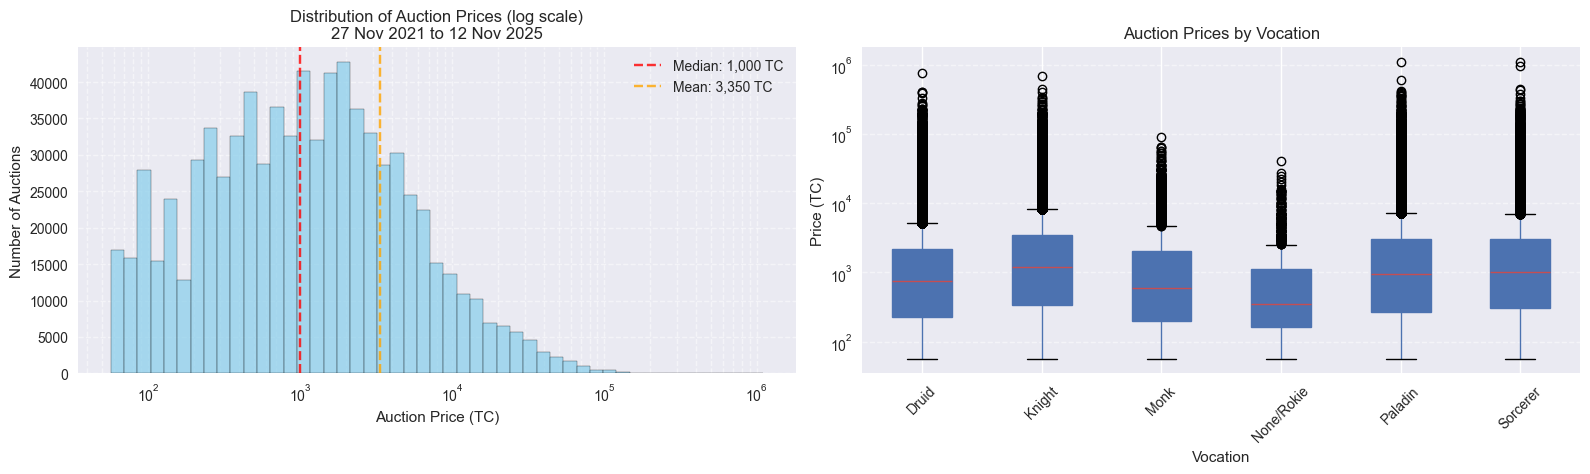

Price Statistics:
Total auctions: 815,152
Price range: 57 - 1,100,000 TC
Median price: 1,000 TC
Mean price: 3,350 TC
95th percentile: 14,001 TC


In [105]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

# Histogram with log-scaled X axis
prices = auctions_df['current_bid'].dropna()
bins = np.logspace(np.log10(prices.min()), np.log10(prices.max()), 50)
ax1.hist(prices, bins=bins, edgecolor='black', alpha=0.7, color='skyblue')
ax1.set_xscale('log')
ax1.set_xlabel('Auction Price (TC)')
ax1.set_ylabel('Number of Auctions')
ax1.set_title('Distribution of Auction Prices (log scale)')
ax1.grid(True, which='both', linestyle='--', alpha=0.5)

# Add date range to title 
date_min = auctions_df['auction_end_dt'].min().strftime('%d %b %Y')  
date_max = auctions_df['auction_end_dt'].max().strftime('%d %b %Y')
ax1.set_title(f'Distribution of Auction Prices (log scale)\n{date_min} to {date_max}')

ax1.grid(True, which='both', linestyle='--', alpha=0.5)

# Add statistics text
median_price = prices.median()
mean_price = prices.mean()
ax1.axvline(median_price, color='red', linestyle='--', alpha=0.8, label=f'Median: {median_price:,.0f} TC')
ax1.axvline(mean_price, color='orange', linestyle='--', alpha=0.8, label=f'Mean: {mean_price:,.0f} TC')
ax1.legend()

# Boxplot by vocation
auctions_df.boxplot(column='current_bid', 
                   by='vocation_name', 
                   ax=ax2,
                   showfliers=True,
                   patch_artist=True)
ax2.set_title('Auction Prices by Vocation')
ax2.set_xlabel('Vocation')
ax2.set_ylabel('Price (TC)')
ax2.set_yscale('log')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(True, axis='y', linestyle='--', alpha=0.5)

# Remove automatic pandas title
plt.suptitle('')
plt.tight_layout()
plt.show()

# Print some insights
print(f"Price Statistics:")
print(f"Total auctions: {len(prices):,}")
print(f"Price range: {prices.min():,} - {prices.max():,} TC")
print(f"Median price: {median_price:,.0f} TC")
print(f"Mean price: {mean_price:,.0f} TC")
print(f"95th percentile: {prices.quantile(0.95):,.0f} TC")
